In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

In [2]:
prices = pd.read_csv('./dataset/tsa_prices.csv', index_col='date', parse_dates=True)
prices.head()

,EBAY,YHOO
date,,
2010-01-04,23.900000,17.100000
2010-01-05,23.650000,17.230000
2010-01-06,23.500000,17.170000
2010-01-07,23.229998,16.700001
2010-01-08,23.509999,16.700001


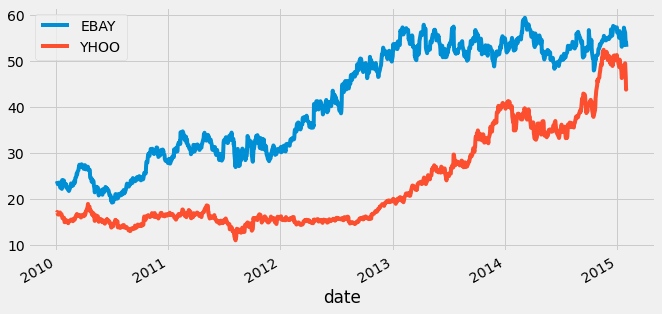

In [3]:
# Plot the raw values over time
prices.plot();

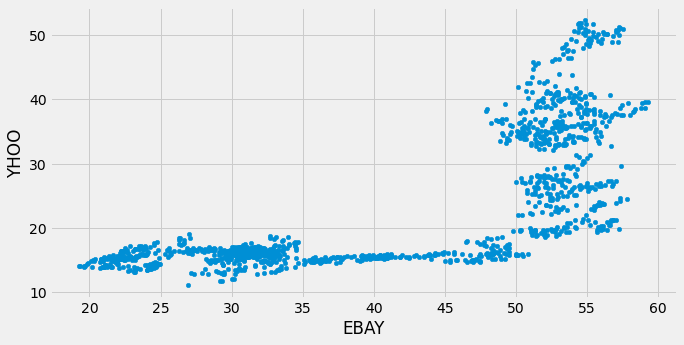

In [4]:
# Scatterplot with one company per axis
prices.plot.scatter('EBAY', 'YHOO');

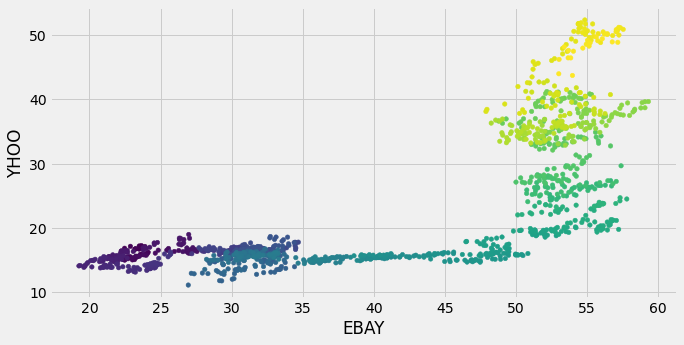

In [5]:
# Scatterplot with color relating to time
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, cmap=plt.cm.viridis, colorbar=False);

In [6]:
all_prices = pd.read_csv('./dataset/all_prices.csv', index_col=0, parse_dates=True)
all_prices.head()

,AAPL,ABT,AIG,AMAT,ARNC,BAC,BSX,C,CHK,CMCSA,...,QCOM,RF,SBUX,T,V,VZ,WFC,XOM,XRX,YHOO
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,214.009998,54.459951,29.889999,14.30,16.650013,15.690000,9.01,3.40,28.090001,16.969999,...,46.939999,5.42,23.049999,28.580000,88.139999,33.279869,27.320000,69.150002,8.63,17.100000
2010-01-05,214.379993,54.019953,29.330000,14.19,16.130013,16.200001,9.04,3.53,28.970002,16.740000,...,48.070000,5.60,23.590000,28.440001,87.129997,33.339868,28.070000,69.419998,8.64,17.230000
2010-01-06,210.969995,54.319953,29.139999,14.16,16.970013,16.389999,9.16,3.64,28.650002,16.620001,...,47.599998,5.67,23.420000,27.610001,85.959999,31.919873,28.110001,70.019997,8.56,17.170000
2010-01-07,210.580000,54.769952,28.580000,14.01,16.610014,16.930000,9.09,3.65,28.720002,16.969999,...,48.980000,6.17,23.360001,27.299999,86.760002,31.729875,29.129999,69.800003,8.60,16.700001
2010-01-08,211.980005,55.049952,29.340000,14.55,17.020014,16.780001,9.00,3.59,28.910002,16.920000,...,49.470001,6.18,23.280001,27.100000,87.000000,31.749874,28.860001,69.519997,8.57,16.700001


In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

X = all_prices[['EBAY', 'NVDA', 'YHOO']]
y = all_prices[['AAPL']]

scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-6.09050633 -0.3179172  -3.72957284]


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,
                                                   shuffle=False, random_state=1)
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

-0.3380697256228937


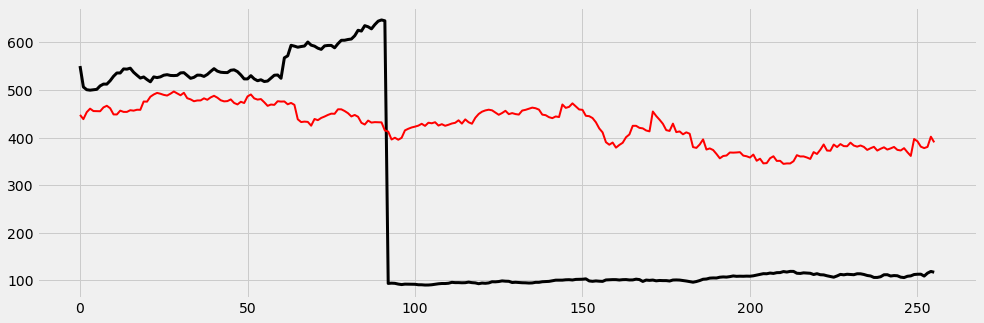

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(range(len(y_test)), y_test, color='k', lw=3);
ax.plot(range(len(predictions)), predictions, color='r', lw=2);

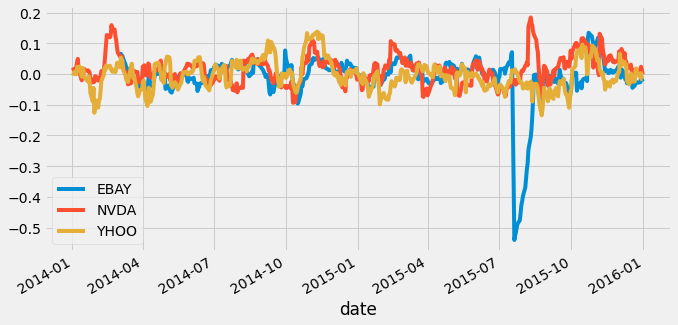

In [16]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]
    
    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot();

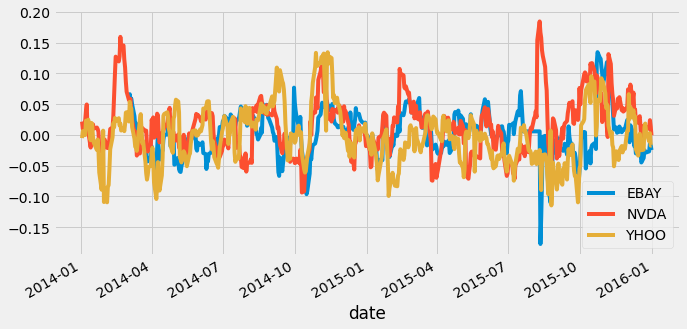

In [17]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the difference that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median across the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing functino to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot();

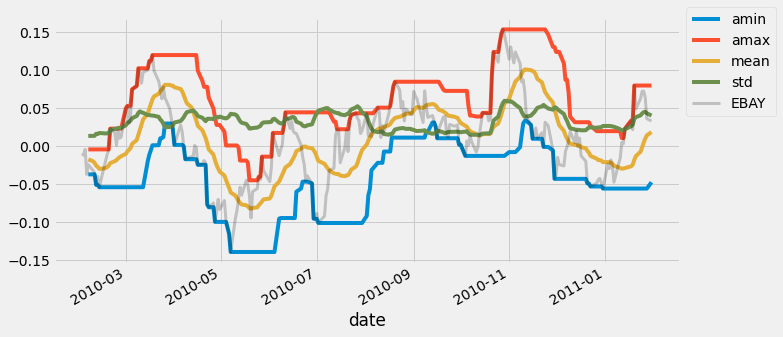

In [18]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc['EBAY'].rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot();
prices_perc['EBAY'].loc[:"2011-01"].plot(ax=ax, color='k', alpha=0.2, lw=3);
ax.legend(loc=(1.01, 0.6));

### Percentiles and partial functions
In this exercise, you'll practice how to pre-choose arguments of a function so that you can pre-configure how it runs. You'll use this to calculate several percentiles of your data using the same ```percentile()``` function in numpy.

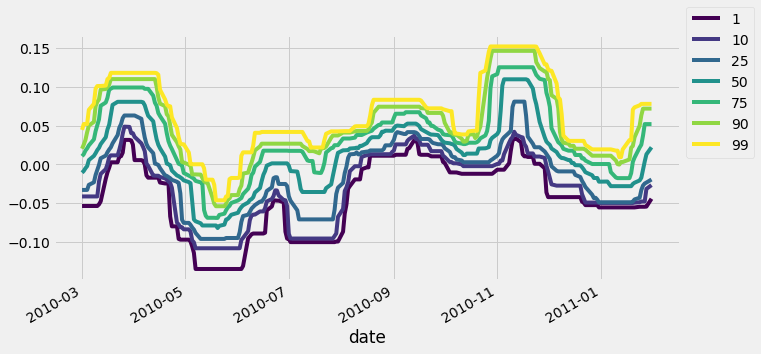

In [20]:
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc['EBAY'].rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis);
ax.legend(percentiles, loc=(1.01, 0.5));
#plt.savefig('../images/price_percentile.png')

### Using "date" information
It's easy to think of timestamps as pure numbers, but don't forget they generally correspond to things that happen in the real world. That means there's often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data.

In [21]:
# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.dayofweek
prices_perc['week_of_year'] = prices_perc.index.weekofyear
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc)

<ipython-input-21-33065db1e4f8>:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  prices_perc['week_of_year'] = prices_perc.index.weekofyear


                EBAY      NVDA      YHOO  day_of_week  week_of_year  \
date                                                                  
2010-01-04       NaN       NaN       NaN            0             1   
2010-01-05       NaN       NaN       NaN            1             1   
2010-01-06       NaN       NaN       NaN            2             1   
2010-01-07       NaN       NaN       NaN            3             1   
2010-01-08       NaN       NaN       NaN            4             1   
...              ...       ...       ...          ...           ...   
2016-12-23  0.024842  0.147720 -0.038006            4            51   
2016-12-27  0.038030  0.014446 -0.027985            1            52   
2016-12-28  0.026925  0.117737 -0.029311            2            52   
2016-12-29  0.021850  0.129669 -0.028632            3            52   
2016-12-30  0.007285  0.068559 -0.026603            4            52   

            month_of_year  
date                       
2010-01-04          